# TensorFlow2.0教程-使用keras训练模型

In [1]:
# !pip install -q pydot
# !apt-get install graphviz

In [2]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
tf.keras.backend.clear_session()
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

## 1.一般的模型构造、训练、测试流程

In [3]:


# 模型构造
inputs = keras.Input(shape=(784,), name='mnist_input')
h1 = layers.Dense(64, activation='relu')(inputs)
h1 = layers.Dense(64, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h1)
model = keras.Model(inputs, outputs)
# keras.utils.plot_model(model, 'net001.png', show_shapes=True)

model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])

# 载入数据
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') /255
x_test = x_test.reshape(10000, 784).astype('float32') /255

x_val = x_train[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
y_train = y_train[:-10000]

# 训练模型
history = model.fit(x_train, y_train, batch_size=64, epochs=3,
         validation_data=(x_val, y_val))
print('history:')
print(history.history)

result = model.evaluate(x_test, y_test, batch_size=128)
print('evaluate:')
print(result)
pred = model.predict(x_test[:2])
print('predict:')
print(pred)



Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 2s 33us/sample - loss: 0.3454 - sparse_categorical_accuracy: 0.9005 - val_loss: 0.1787 - val_sparse_categorical_accuracy: 0.9482
Epoch 2/3
50000/50000 [==============================] - 1s 27us/sample - loss: 0.1575 - sparse_categorical_accuracy: 0.9529 - val_loss: 0.1412 - val_sparse_categorical_accuracy: 0.9585
Epoch 3/3
50000/50000 [==============================] - 1s 28us/sample - loss: 0.1169 - sparse_categorical_accuracy: 0.9650 - val_loss: 0.1235 - val_sparse_categorical_accuracy: 0.9648
history:
{'loss': [0.3453604544830322, 0.1575087631160021, 0.11689146610498428], 'sparse_categorical_accuracy': [0.90052, 0.95286, 0.96496], 'val_loss': [0.17870783286094666, 0.14119704793691634, 0.12352603247761726], 'val_sparse_categorical_accuracy': [0.9482, 0.9585, 0.9648]}
10000/10000 [==============================] - 0s 9us/sample - loss: 0.1278 - sparse_categorical_accuracy: 0.9620

## 2.自定义损失和指标
自定义指标只需继承Metric类， 并重写一下函数

\__init\__(self)，初始化。

update_state(self，y_true，y_pred，sample_weight = None)，它使用目标y_true和模型预测y_pred来更新状态变量。

result(self)，它使用状态变量来计算最终结果。

reset_states(self)，重新初始化度量的状态。


In [6]:
# 这是一个简单的示例，显示如何实现CatgoricalTruePositives指标，该指标计算正确分类为属于给定类的样本数量

class CatgoricalTruePostives(keras.metrics.Metric):
    def __init__(self, name='binary_true_postives', **kwargs):
        super(CatgoricalTruePostives, self).__init__(name=name, **kwargs)
        self.true_postives = self.add_weight(name='tp', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred)
        y_true = tf.equal(tf.cast(y_pred, tf.int32), tf.cast(y_true, tf.int32))
        
        y_true = tf.cast(y_true, tf.float32)
        
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            y_true = tf.multiply(sample_weight, y_true)
            
        return self.true_postives.assign_add(tf.reduce_sum(y_true))
    
    def result(self):
        return tf.identity(self.true_postives)
    
    def reset_states(self):
        self.true_postives.assign(0.)
        

model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[CatgoricalTruePostives()])

model.fit(x_train, y_train,
         batch_size=64, epochs=3)
            
            
            

Epoch 1/3
50000/50000 [==============================] - 1s 27us/sample - loss: 0.0590 - binary_true_postives: 9186.0000
Epoch 2/3
50000/50000 [==============================] - 1s 24us/sample - loss: 0.0499 - binary_true_postives: 9957.0000
Epoch 3/3
50000/50000 [==============================] - 1s 25us/sample - loss: 0.0441 - binary_true_postives: 10939.0000


In [10]:
# 以定义网络层的方式添加网络loss
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs) * 0.1)
        return inputs

inputs = keras.Input(shape=(784,), name='mnist_input')
h1 = layers.Dense(64, activation='relu')(inputs)
h1 = ActivityRegularizationLayer()(h1)
h1 = layers.Dense(64, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h1)
model = keras.Model(inputs, outputs)
# keras.utils.plot_model(model, 'net001.png', show_shapes=True)

model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(x_train, y_train, batch_size=32, epochs=1)

50000/50000 [==============================] - 2s 44us/sample - loss: 2.3663 - sparse_categorical_accuracy: 0.1135


In [11]:
# 也可以以定义网络层的方式添加要统计的metric
class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        self.add_metric(keras.backend.std(inputs),
                       name='std_of_activation',
                       aggregation='mean')
        
        return inputs

inputs = keras.Input(shape=(784,), name='mnist_input')
h1 = layers.Dense(64, activation='relu')(inputs)
h1 = MetricLoggingLayer()(h1)
h1 = layers.Dense(64, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h1)
model = keras.Model(inputs, outputs)
# keras.utils.plot_model(model, 'net001.png', show_shapes=True)

model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(x_train, y_train, batch_size=32, epochs=1)

50000/50000 [==============================] - 2s 47us/sample - loss: 0.3014 - sparse_categorical_accuracy: 0.9104 - std_of_activation: 0.9998


In [13]:
# 也可以直接在model上面加
# 也可以以定义网络层的方式添加要统计的metric
class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        self.add_metric(keras.backend.std(inputs),
                       name='std_of_activation',
                       aggregation='mean')
        
        return inputs

inputs = keras.Input(shape=(784,), name='mnist_input')
h1 = layers.Dense(64, activation='relu')(inputs)
h2 = layers.Dense(64, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h2)
model = keras.Model(inputs, outputs)

model.add_metric(keras.backend.std(inputs),
                       name='std_of_activation',
                       aggregation='mean')
model.add_loss(tf.reduce_sum(h1)*0.1)

# keras.utils.plot_model(model, 'net001.png', show_shapes=True)

model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(x_train, y_train, batch_size=32, epochs=1)

50000/50000 [==============================] - 2s 46us/sample - loss: 2.3472 - sparse_categorical_accuracy: 0.1128 - std_of_activation: 0.3083


处理使用validation_data传入测试数据，还可以使用validation_split划分验证数据

ps:validation_split只能在用numpy数据训练的情况下使用

In [14]:


model.fit(x_train, y_train, batch_size=32, epochs=1, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 2s 55us/sample - loss: 2.3012 - sparse_categorical_accuracy: 0.1141 - std_of_activation: 0.3087 - val_loss: 2.3016 - val_sparse_categorical_accuracy: 0.1115 - val_std_of_activation: 0.3065


## 3.使用tf.data构造数据

In [18]:
def get_compiled_model():
    inputs = keras.Input(shape=(784,), name='mnist_input')
    h1 = layers.Dense(64, activation='relu')(inputs)
    h2 = layers.Dense(64, activation='relu')(h1)
    outputs = layers.Dense(10, activation='softmax')(h2)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.RMSprop(),
                 loss=keras.losses.SparseCategoricalCrossentropy(),
                 metrics=[keras.metrics.SparseCategoricalAccuracy()])
    return model
model = get_compiled_model()
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

# model.fit(train_dataset, epochs=3)
# steps_per_epoch 每个epoch只训练几步
# validation_steps 每次验证，验证几步
model.fit(train_dataset, epochs=3, steps_per_epoch=100,
         validation_data=val_dataset, validation_steps=3)



Epoch 1/3
100/100 [==============================] - 1s 10ms/step - loss: 0.7865 - sparse_categorical_accuracy: 0.7986 - val_loss: 0.3783 - val_sparse_categorical_accuracy: 0.8969
Epoch 2/3
100/100 [==============================] - 1s 5ms/step - loss: 0.3660 - sparse_categorical_accuracy: 0.8963 - val_loss: 0.3103 - val_sparse_categorical_accuracy: 0.9076
Epoch 3/3
100/100 [==============================] - 1s 5ms/step - loss: 0.3195 - sparse_categorical_accuracy: 0.9036 - val_loss: 0.2533 - val_sparse_categorical_accuracy: 0.9226


## 4.样本权重和类权重
“样本权重”数组是一个数字数组，用于指定批处理中每个样本在计算总损失时应具有多少权重。 它通常用于不平衡的分类问题（这个想法是为了给予很少见的类更多的权重）。 当使用的权重是1和0时，该数组可以用作损失函数的掩码（完全丢弃某些样本对总损失的贡献）。

“类权重”dict是同一概念的更具体的实例：它将类索引映射到应该用于属于该类的样本的样本权重。 例如，如果类“0”比数据中的类“1”少两倍，则可以使用class_weight = {0：1.，1：0.5}。

In [23]:
# 增加第5类的权重
import numpy as np
# 类权重
model = get_compiled_model()
class_weight = {i:1.0 for i in range(10)}
class_weight[5] = 2.0
print(class_weight)
model.fit(x_train, y_train,
         class_weight=class_weight,
         batch_size=64,
         epochs=4)
# 样本权重
model = get_compiled_model()
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0
model.fit(x_train, y_train,
         sample_weight=sample_weight,
         batch_size=64,
         epochs=4)


{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 2.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0}
Epoch 1/4
50000/50000 [==============================] - 1s 26us/sample - loss: 0.3734 - sparse_categorical_accuracy: 0.9020
Epoch 2/4
50000/50000 [==============================] - 1s 24us/sample - loss: 0.1698 - sparse_categorical_accuracy: 0.9518
Epoch 3/4
50000/50000 [==============================] - 1s 24us/sample - loss: 0.1254 - sparse_categorical_accuracy: 0.9644
Epoch 4/4
50000/50000 [==============================] - 1s 25us/sample - loss: 0.1001 - sparse_categorical_accuracy: 0.9709
Epoch 1/4
50000/50000 [==============================] - 1s 27us/sample - loss: 0.3742 - sparse_categorical_accuracy: 0.9014
Epoch 2/4
50000/50000 [==============================] - 1s 24us/sample - loss: 0.1772 - sparse_categorical_accuracy: 0.9504
Epoch 3/4
50000/50000 [==============================] - 1s 25us/sample - loss: 0.1286 - sparse_categorical_accuracy: 0.9633
Epoch 4/4
50000/50000 [=====================

In [24]:
# tf.data数据
model = get_compiled_model()

sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train,
                                                    sample_weight))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=3, )

Epoch 1/3
782/782 [==============================] - 2s 3ms/step - loss: 0.3669 - sparse_categorical_accuracy: 0.9025
Epoch 2/3
782/782 [==============================] - 2s 3ms/step - loss: 0.1709 - sparse_categorical_accuracy: 0.9536
Epoch 3/3
782/782 [==============================] - 2s 3ms/step - loss: 0.1252 - sparse_categorical_accuracy: 0.9659


## 5.多输入多输出模型

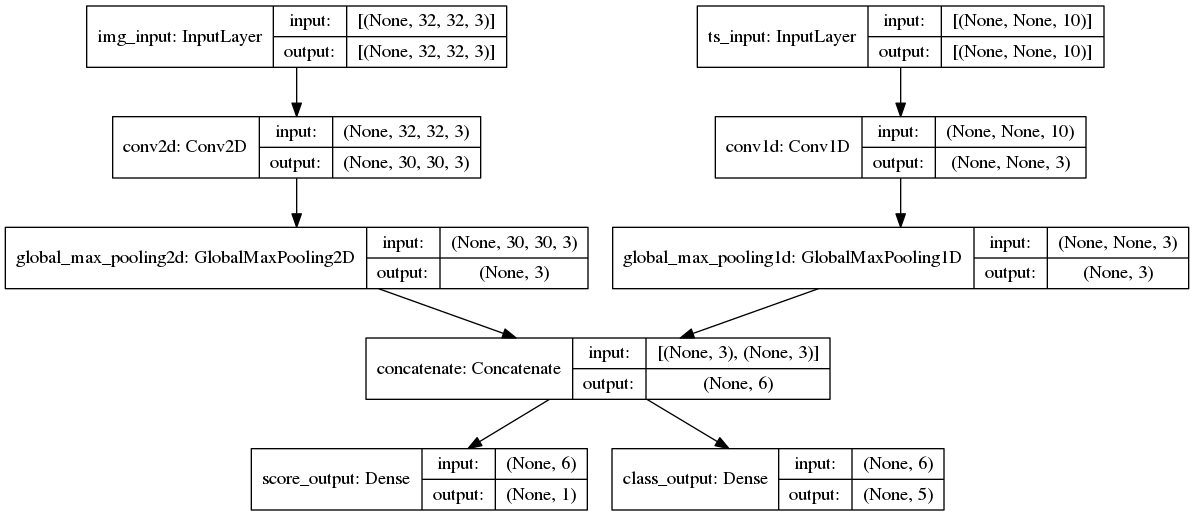

In [25]:
image_input = keras.Input(shape=(32, 32, 3), name='img_input')
timeseries_input = keras.Input(shape=(None, 10), name='ts_input')

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name='score_output')(x)
class_output = layers.Dense(5, activation='softmax', name='class_output')(x)

model = keras.Model(inputs=[image_input, timeseries_input],
                    outputs=[score_output, class_output])
keras.utils.plot_model(model, 'multi_input_output_model.png'
                       , show_shapes=True)

In [ ]:
# 可以为模型指定不同的loss和metrics
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(),
          keras.losses.CategoricalCrossentropy()])

# 还可以指定loss的权重
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={'score_output': keras.losses.MeanSquaredError(),
          'class_output': keras.losses.CategoricalCrossentropy()},
    metrics={'score_output': [keras.metrics.MeanAbsolutePercentageError(),
                              keras.metrics.MeanAbsoluteError()],
             'class_output': [keras.metrics.CategoricalAccuracy()]},
    loss_weight={'score_output': 2., 'class_output': 1.})

# 可以把不需要传播的loss置0
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy()])

# Or dict loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={'class_output': keras.losses.CategoricalCrossentropy()})

## 6.使用回调
Keras中的回调是在训练期间（在epoch开始时，batch结束时，epoch结束时等）在不同点调用的对象，可用于实现以下行为：

- 在培训期间的不同时间点进行验证（超出内置的每个时期验证）
- 定期检查模型或超过某个精度阈值
- 在训练似乎平稳时改变模型的学习率
- 在训练似乎平稳时对顶层进行微调
- 在培训结束或超出某个性能阈值时发送电子邮件或即时消息通知等等。

**可使用的内置回调有**

- ModelCheckpoint：定期保存模型。
- EarlyStopping：当训练不再改进验证指标时停止培训。
- TensorBoard：定期编写可在TensorBoard中显示的模型日志（更多细节见“可视化”）。
- CSVLogger：将丢失和指标数据流式传输到CSV文件。
- 等等

### 6.1回调使用

In [27]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1)
]
model.fit(x_train, y_train,
          epochs=20,
          batch_size=64,
          callbacks=callbacks,
          validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 1s 33us/sample - loss: 0.3769 - sparse_categorical_accuracy: 0.8937 - val_loss: 0.2263 - val_sparse_categorical_accuracy: 0.9324
Epoch 2/20
40000/40000 [==============================] - 1s 31us/sample - loss: 0.1751 - sparse_categorical_accuracy: 0.9477 - val_loss: 0.1810 - val_sparse_categorical_accuracy: 0.9465
Epoch 3/20
40000/40000 [==============================] - 1s 31us/sample - loss: 0.1274 - sparse_categorical_accuracy: 0.9611 - val_loss: 0.1585 - val_sparse_categorical_accuracy: 0.9529
Epoch 4/20
40000/40000 [==============================] - 1s 29us/sample - loss: 0.1017 - sparse_categorical_accuracy: 0.9693 - val_loss: 0.1490 - val_sparse_categorical_accuracy: 0.9578
Epoch 5/20
40000/40000 [==============================] - 1s 31us/sample - loss: 0.0829 - sparse_categorical_accuracy: 0.9748 - val_loss: 0.1570 - val_sparse_categorical_accuracy: 0.9567
Epoch 00005: ea

In [34]:
# checkpoint模型回调
model = get_compiled_model()
check_callback = keras.callbacks.ModelCheckpoint(
    filepath='mymodel_{epoch}.h5',
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

model.fit(x_train, y_train,
         epochs=3,
         batch_size=64,
         callbacks=[check_callback],
         validation_split=0.2)



Train on 40000 samples, validate on 10000 samples
Epoch 1/3
37824/40000 [===========================>..] - ETA: 0s - loss: 0.3671 - sparse_categorical_accuracy: 0.8974
Epoch 00001: val_loss improved from inf to 0.22616, saving model to mymodel_1.h5
40000/40000 [==============================] - 1s 34us/sample - loss: 0.3588 - sparse_categorical_accuracy: 0.8996 - val_loss: 0.2262 - val_sparse_categorical_accuracy: 0.9309
Epoch 2/3
39552/40000 [============================>.] - ETA: 0s - loss: 0.1673 - sparse_categorical_accuracy: 0.9499
Epoch 00002: val_loss improved from 0.22616 to 0.17153, saving model to mymodel_2.h5
40000/40000 [==============================] - 1s 29us/sample - loss: 0.1667 - sparse_categorical_accuracy: 0.9501 - val_loss: 0.1715 - val_sparse_categorical_accuracy: 0.9484
Epoch 3/3
39744/40000 [============================>.] - ETA: 0s - loss: 0.1217 - sparse_categorical_accuracy: 0.9629
Epoch 00003: val_loss improved from 0.17153 to 0.15758, saving model to mymode

In [35]:
# 动态调整学习率
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)
optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

In [40]:
# 使用tensorboard
tensorboard_cbk = keras.callbacks.TensorBoard(log_dir='./full_path_to_your_logs')
model.fit(x_train, y_train,
         epochs=5,
         batch_size=64,
         callbacks=[tensorboard_cbk],
         validation_split=0.2)


Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 1s 26us/sample - loss: 0.0577 - sparse_categorical_accuracy: 0.9824 - val_loss: 0.1433 - val_sparse_categorical_accuracy: 0.9630
Epoch 2/5
40000/40000 [==============================] - 1s 25us/sample - loss: 0.0509 - sparse_categorical_accuracy: 0.9843 - val_loss: 0.1445 - val_sparse_categorical_accuracy: 0.9626
Epoch 3/5
40000/40000 [==============================] - 1s 26us/sample - loss: 0.0442 - sparse_categorical_accuracy: 0.9865 - val_loss: 0.1384 - val_sparse_categorical_accuracy: 0.9641
Epoch 4/5
40000/40000 [==============================] - 1s 25us/sample - loss: 0.0379 - sparse_categorical_accuracy: 0.9883 - val_loss: 0.1453 - val_sparse_categorical_accuracy: 0.9654
Epoch 5/5
40000/40000 [==============================] - 1s 28us/sample - loss: 0.0337 - sparse_categorical_accuracy: 0.9898 - val_loss: 0.1508 - val_sparse_categorical_accuracy: 0.9626


### 6.2创建自己的回调方法


In [32]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.losses = []
    def on_epoch_end(self, batch, logs):
        self.losses.append(logs.get('loss'))
        print('\nloss:',self.losses[-1])
        
model = get_compiled_model()

callbacks = [
    LossHistory()
]
model.fit(x_train, y_train,
          epochs=3,
          batch_size=64,
          callbacks=callbacks,
          validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/3
39616/40000 [============================>.] - ETA: 0s - loss: 0.3804 - sparse_categorical_accuracy: 0.8905
loss: 0.3786653545618057
40000/40000 [==============================] - 1s 33us/sample - loss: 0.3787 - sparse_categorical_accuracy: 0.8910 - val_loss: 0.2354 - val_sparse_categorical_accuracy: 0.9290
Epoch 2/3
38592/40000 [===========================>..] - ETA: 0s - loss: 0.1771 - sparse_categorical_accuracy: 0.9487
loss: 0.17603070653378963
40000/40000 [==============================] - 1s 28us/sample - loss: 0.1760 - sparse_categorical_accuracy: 0.9490 - val_loss: 0.1762 - val_sparse_categorical_accuracy: 0.9452
Epoch 3/3
37952/40000 [===========================>..] - ETA: 0s - loss: 0.1291 - sparse_categorical_accuracy: 0.9605
loss: 0.12881728459894656
40000/40000 [==============================] - 1s 29us/sample - loss: 0.1288 - sparse_categorical_accuracy: 0.9607 - val_loss: 0.1470 - val_sparse_categorical_accuracy

## 7.自己构造训练和验证循环

In [42]:
# Get the model.
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Instantiate an optimizer.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy()

# Prepare the training dataset.
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# 自己构造循环
for epoch in range(3):
    print('epoch: ', epoch)
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        # 开一个gradient tape, 计算梯度
        with tf.GradientTape() as tape:
            logits = model(x_batch_train)
            
            loss_value = loss_fn(y_batch_train, logits)
            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
        if step % 200 == 0:
            print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
            print('Seen so far: %s samples' % ((step + 1) * 64))
            

epoch:  0
Training loss (for one batch) at step 0: 2.3296241760253906
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.2373404502868652
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.171706199645996
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.155531167984009
Seen so far: 38464 samples
epoch:  1
Training loss (for one batch) at step 0: 2.0785980224609375
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.9483530521392822
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.8693970441818237
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 1.8084864616394043
Seen so far: 38464 samples
epoch:  2
Training loss (for one batch) at step 0: 1.7550199031829834
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.5734221935272217
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.4772768020629883
Seen so far: 25664 samples
Training

In [43]:
# 训练并验证
# Get model
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Instantiate an optimizer to train the model.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy()

# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy() 
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# Prepare the training dataset.
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)


# Iterate over epochs.
for epoch in range(3):
  print('Start of epoch %d' % (epoch,))
  
  # Iterate over the batches of the dataset.
  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      logits = model(x_batch_train)
      loss_value = loss_fn(y_batch_train, logits)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
      
    # Update training metric.
    train_acc_metric(y_batch_train, logits)

    # Log every 200 batches.
    if step % 200 == 0:
        print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        print('Seen so far: %s samples' % ((step + 1) * 64))

  # Display metrics at the end of each epoch.
  train_acc = train_acc_metric.result()
  print('Training acc over epoch: %s' % (float(train_acc),))
  # Reset training metrics at the end of each epoch
  train_acc_metric.reset_states()

  # Run a validation loop at the end of each epoch.
  for x_batch_val, y_batch_val in val_dataset:
    val_logits = model(x_batch_val)
    # Update val metrics
    val_acc_metric(y_batch_val, val_logits)
  val_acc = val_acc_metric.result()
  val_acc_metric.reset_states()
  print('Validation acc: %s' % (float(val_acc),))

Start of epoch 0
Training loss (for one batch) at step 0: 2.3331069946289062
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.2623767852783203
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.247002124786377
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.160977363586426
Seen so far: 38464 samples
Training acc over epoch: 0.18501999974250793
Validation acc: 0.2630999982357025
Start of epoch 1
Training loss (for one batch) at step 0: 2.151536464691162
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.051269054412842
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.0531749725341797
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 1.8794834613800049
Seen so far: 38464 samples
Training acc over epoch: 0.3834800124168396
Validation acc: 0.5056999921798706
Start of epoch 2
Training loss (for one batch) at step 0: 1.9189088344573975
Seen so far: 64 samples
Training

In [44]:
##　添加自己构造的loss, 每次只能看到最新一次训练增加的loss
class ActivityRegularizationLayer(layers.Layer):
  
  def call(self, inputs):
    self.add_loss(1e-2 * tf.reduce_sum(inputs))
    return inputs
  
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
# Insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
logits = model(x_train[:64])
print(model.losses)
logits = model(x_train[:64])
logits = model(x_train[64: 128])
logits = model(x_train[128: 192])
print(model.losses)


[<tf.Tensor: id=1213104, shape=(), dtype=float32, numpy=5.6658335>]
[<tf.Tensor: id=1213165, shape=(), dtype=float32, numpy=5.709879>]


In [45]:
# 将loss添加进求导中
optimizer = keras.optimizers.SGD(learning_rate=1e-3)

for epoch in range(3):
  print('Start of epoch %d' % (epoch,))

  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      logits = model(x_batch_train)
      loss_value = loss_fn(y_batch_train, logits)

      # Add extra losses created during this forward pass:
      loss_value += sum(model.losses)
      
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Log every 200 batches.
    if step % 200 == 0:
        print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        print('Seen so far: %s samples' % ((step + 1) * 64))

Start of epoch 0
Training loss (for one batch) at step 0: 8.212984085083008
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.4881486892700195
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.4067013263702393
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.352705240249634
Seen so far: 38464 samples
Start of epoch 1
Training loss (for one batch) at step 0: 2.3271288871765137
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.319481611251831
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.33414363861084
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.3231465816497803
Seen so far: 38464 samples
Start of epoch 2
Training loss (for one batch) at step 0: 2.310762882232666
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.3086767196655273
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.323223352432251
Seen so far: 25664 